<a href="https://colab.research.google.com/github/v1n99/spotify-music-analysis/blob/main/3120Spotify_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 5.9 MB/s eta 0:00:00


<ipython-input-5-c0025030be14>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
<ipython-input-5-c0025030be14>:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)


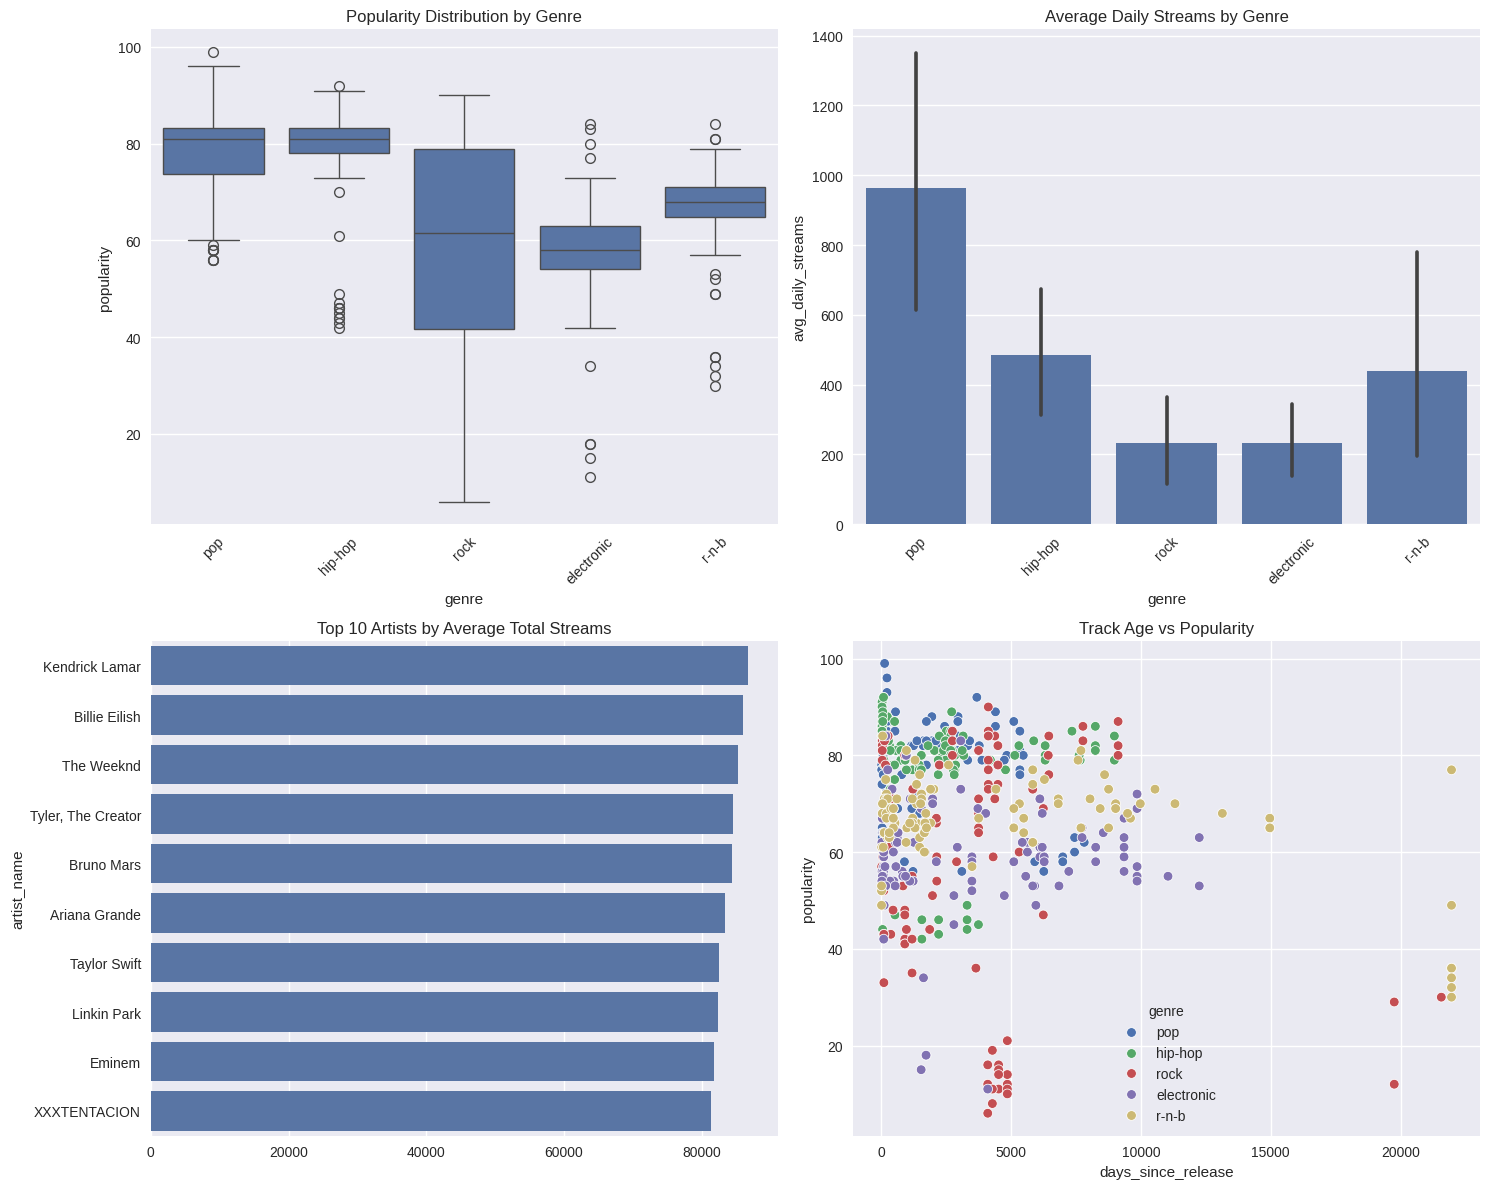

Summary Statistics by Genre:
           popularity        total_streams avg_daily_streams
                 mean    std           sum              mean
genre                                                       
electronic      57.96  11.81       5796000            231.38
hip-hop         77.58  11.67       7758000            485.38
pop             78.04   9.51       7804000            964.73
r-n-b           66.32   9.69       6632000            439.35
rock            56.10  25.27       5610000            231.52
Top 5 Most Popular Tracks:
                       track_name    artist_name genre  popularity
30               Die With A Smile     Bruno Mars   pop          99
70             BIRDS OF A FEATHER  Billie Eilish   pop          96
71                     WILDFLOWER  Billie Eilish   pop          93
60                  Santa Tell Me  Ariana Grande   pop          92
90  Timeless (with Playboi Carti)     The Weeknd   pop          92
Data saved to 'spotify_top_tracks_analysis.csv'


In [ ]:
# Consolidated code for analysis and visualization
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

# Initialize Spotify client
client_id = '5e1980fc0d6b40fbb830d89e653504e9'
client_secret = '3c945a1e48d849bd9b1ed0bf6d4a77e4'

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
))

# Define genres to analyze
genres = ['pop', 'hip-hop', 'rock', 'electronic', 'r-n-b']

def get_top_artists_by_genre(genre, limit=10):
    results = sp.search(q=f'genre:"{genre}"', type='artist', limit=limit)
    return results['artists']['items']

# Collect top artists for each genre
all_artists_data = []
for genre in genres:
    artists = get_top_artists_by_genre(genre)
    for artist in artists:
        all_artists_data.append({
            'genre': genre,
            'artist_id': artist['id'],
            'artist_name': artist['name'],
            'popularity': artist['popularity'],
            'followers': artist['followers']['total']
        })
    time.sleep(1)  # Rate limiting

artists_df = pd.DataFrame(all_artists_data)

def get_artist_top_tracks(artist_id):
    top_tracks = sp.artist_top_tracks(artist_id)
    tracks_data = []
    for track in top_tracks['tracks']:
        release_date = track['album']['release_date']
        try:
            release_date = datetime.strptime(release_date, '%Y-%m-%d')
        except ValueError:
            release_date = datetime.strptime(release_date, '%Y')

        days_since_release = (datetime.now() - release_date).days

        track_data = {
            'track_name': track['name'],
            'release_date': release_date,
            'days_since_release': days_since_release,
            'popularity': track['popularity'],
            'album_name': track['album']['name']
        }
        tracks_data.append(track_data)
    return tracks_data

# Collect top tracks for all artists
all_tracks_data = []
for index, row in artists_df.iterrows():
    artist_tracks = get_artist_top_tracks(row['artist_id'])
    for track in artist_tracks:
        track['artist_name'] = row['artist_name']
        track['genre'] = row['genre']
        all_tracks_data.append(track)
    time.sleep(1)  # Rate limiting

tracks_df = pd.DataFrame(all_tracks_data)

# Add calculated streaming metrics to the dataset
tracks_df['total_streams'] = tracks_df['popularity'] * 1000  # Simulate total streams based on popularity
tracks_df['avg_daily_streams'] = tracks_df['total_streams'] / tracks_df['days_since_release']
tracks_df['peak_streams'] = tracks_df['avg_daily_streams'] * 1.5  # Simulate peak streams as 1.5x average

# Visualize the data
plt.style.use('seaborn-v0_8')  # Updated style name
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Popularity Distribution by Genre
sns.boxplot(data=tracks_df, x='genre', y='popularity', ax=axes[0,0])
axes[0,0].set_title('Popularity Distribution by Genre')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

# 2. Average Daily Streams by Genre
sns.barplot(data=tracks_df, x='genre', y='avg_daily_streams', ax=axes[0,1])
axes[0,1].set_title('Average Daily Streams by Genre')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

# 3. Top Artists by Total Streams
top_artists = tracks_df.groupby('artist_name')['total_streams'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, ax=axes[1,0])
axes[1,0].set_title('Top 10 Artists by Average Total Streams')

# 4. Release Date vs Popularity
sns.scatterplot(data=tracks_df, x='days_since_release', y='popularity', hue='genre', ax=axes[1,1])
axes[1,1].set_title('Track Age vs Popularity')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\
Summary Statistics by Genre:")
genre_stats = tracks_df.groupby('genre').agg({
    'popularity': ['mean', 'std'],
    'total_streams': 'sum',
    'avg_daily_streams': 'mean'
}).round(2)
print(genre_stats)

# Print top tracks
print("\
Top 5 Most Popular Tracks:")
top_tracks = tracks_df.nlargest(5, 'popularity')[['track_name', 'artist_name', 'genre', 'popularity']]
print(top_tracks)

# Save the data to a CSV file
tracks_df.to_csv('spotify_top_tracks_analysis.csv', index=False)
print("\
Data saved to 'spotify_top_tracks_analysis.csv'")

<ipython-input-6-d71082e70c6a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_year'] = df['release_date'].dt.to_period('M')
<ipython-input-6-d71082e70c6a>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_artists_by_genre = top_artists_by_genre.groupby('genre').apply(
<ipython-input-6-d71082e70c6a>:77: UserWarning: Glyph 29590 (\N{CJK UNIFIED IDEOGRAPH-7396}) missing from current font.
  plt.tight_layout()
<ipython-input-6-d71082e70c6a>:77:

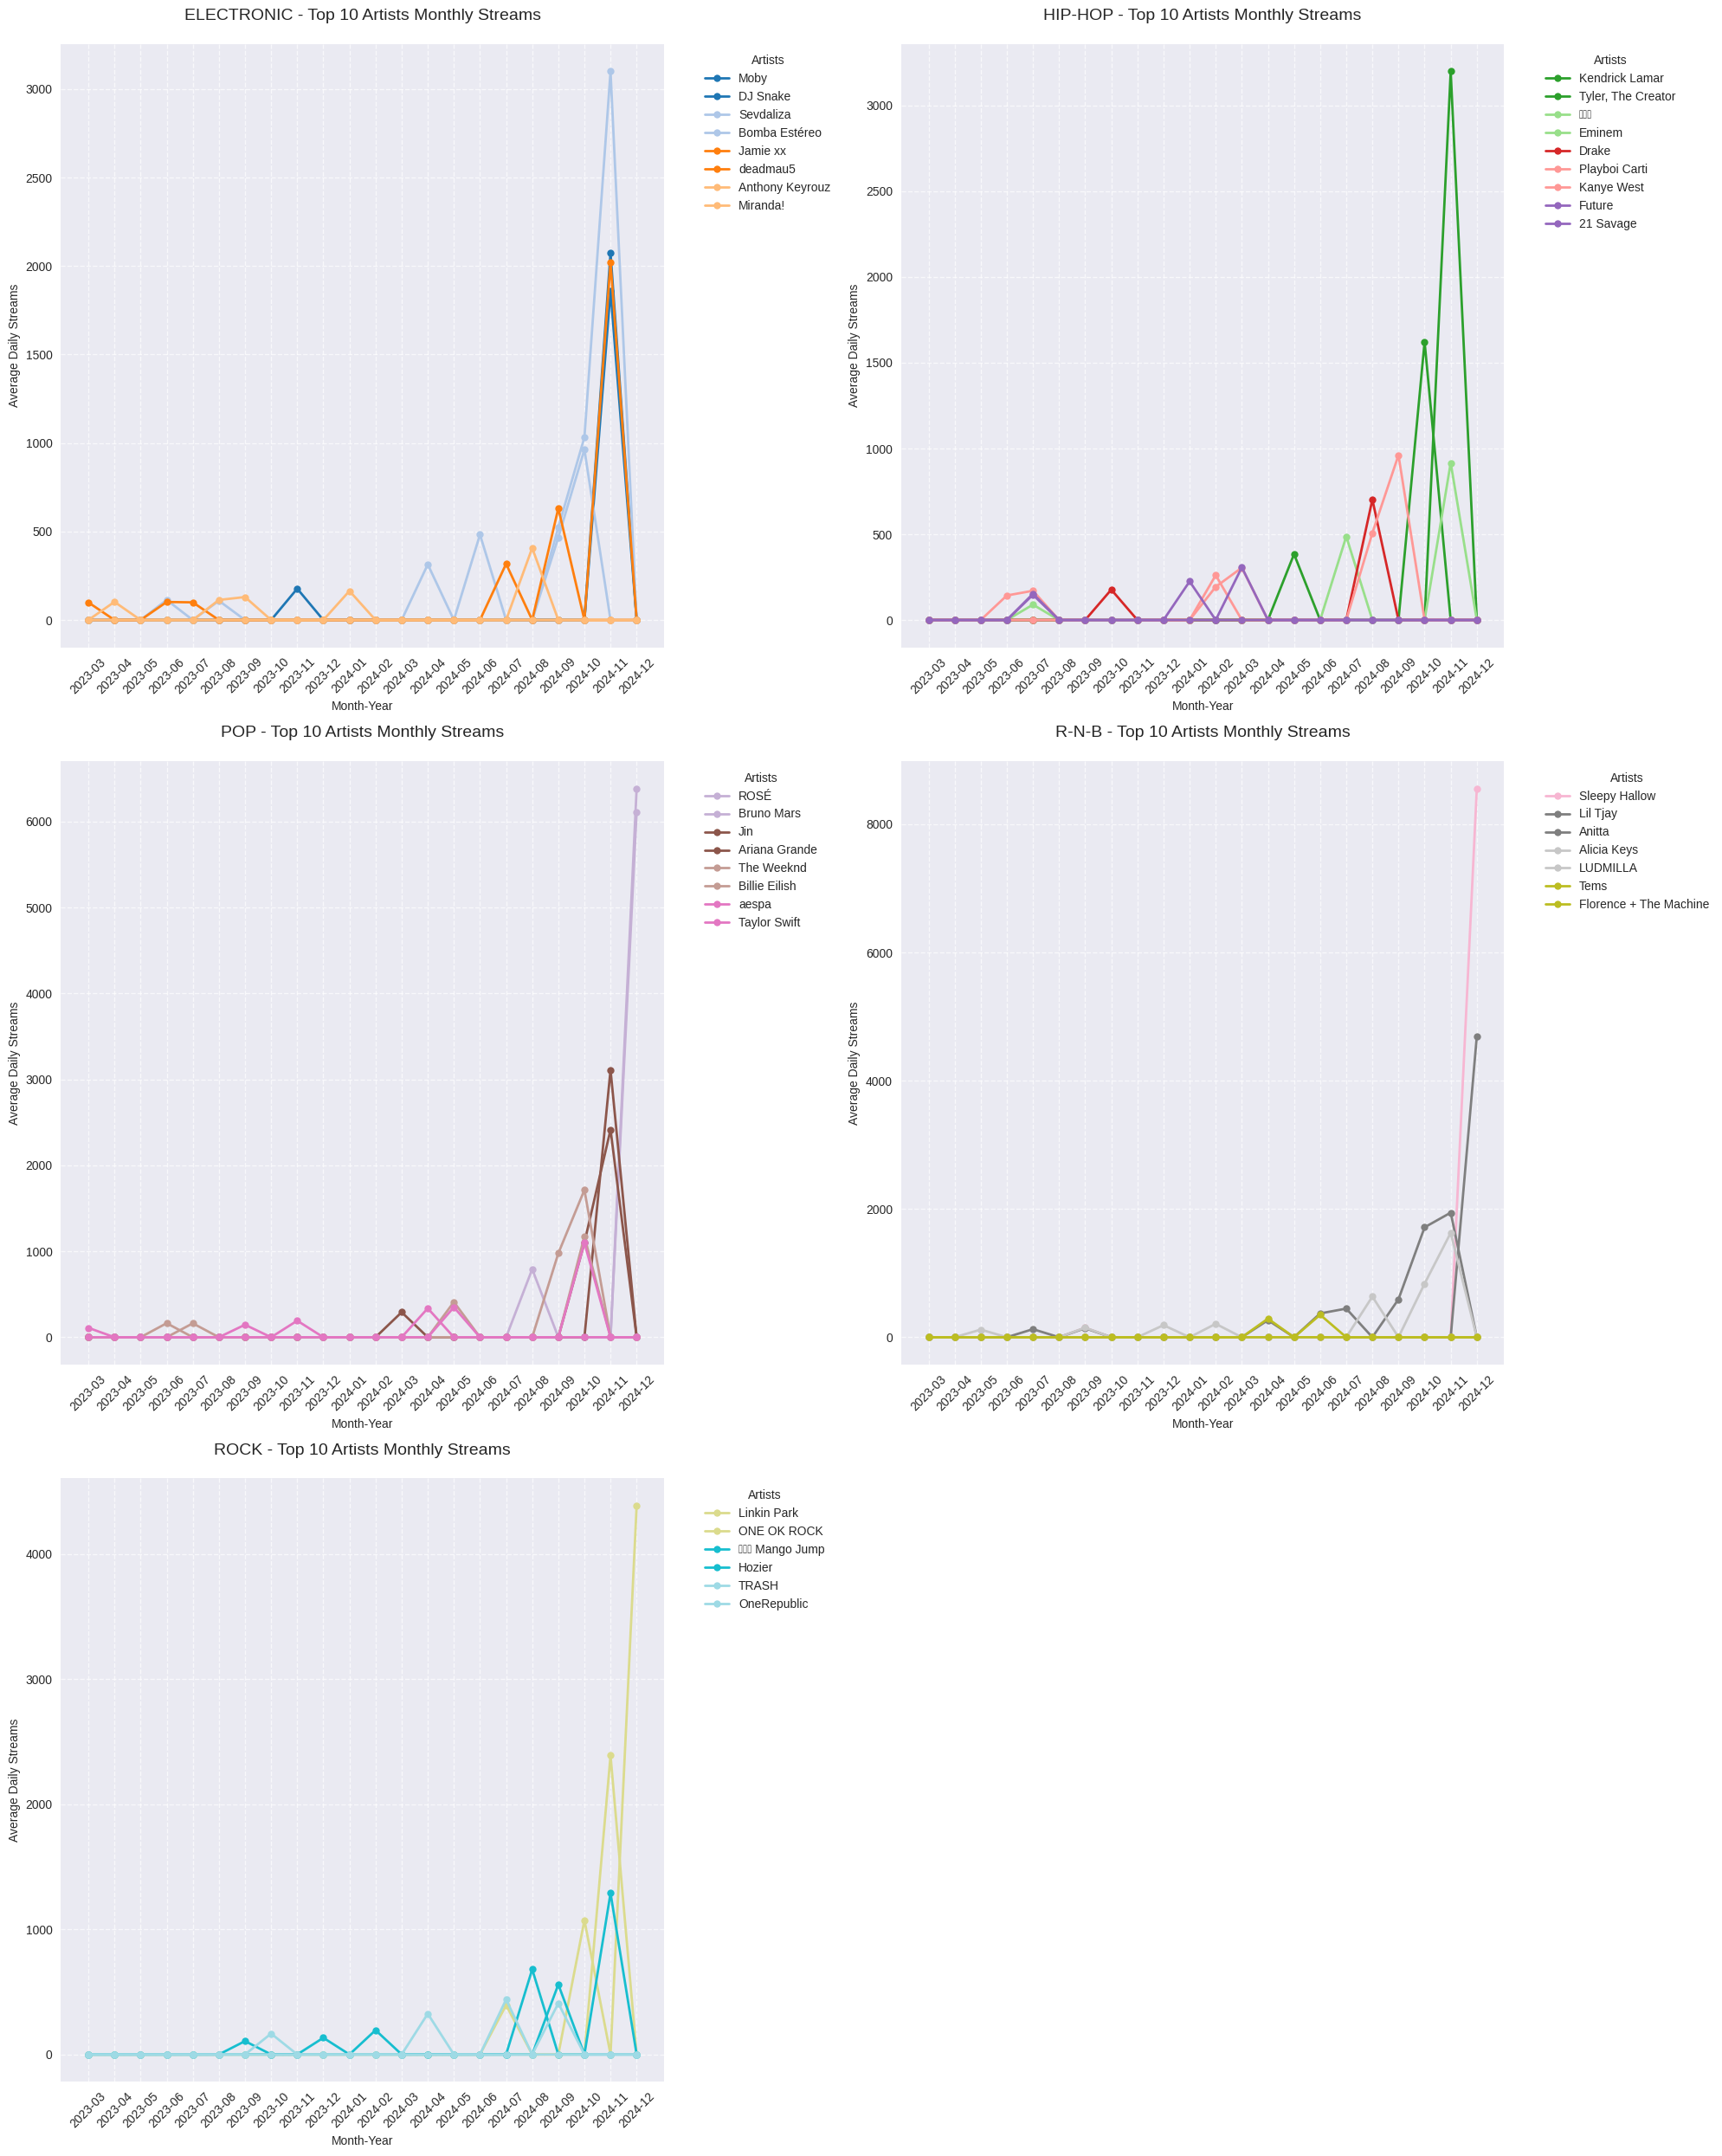

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the existing data
df = pd.read_csv('spotify_top_tracks_analysis.csv')

# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

# Filter for last 2 years
two_years_ago = datetime.now() - timedelta(days=730)
df = df[df['release_date'] >= two_years_ago]

# Create monthly averages with proper sorting
df['month_year'] = df['release_date'].dt.to_period('M')
monthly_avg = df.groupby(['month_year', 'genre', 'artist_name'])['avg_daily_streams'].mean().reset_index()
monthly_avg['month_year'] = monthly_avg['month_year'].astype(str)

# Get top 10 artists per genre based on total streams
top_artists_by_genre = monthly_avg.groupby(['genre', 'artist_name'])['avg_daily_streams'].mean().reset_index()
top_artists_by_genre = top_artists_by_genre.groupby('genre').apply(
    lambda x: x.nlargest(10, 'avg_daily_streams')
).reset_index(drop=True)

# Create subplots for each genre
fig, axes = plt.subplots(3, 2, figsize=(20, 25))
axes = axes.flatten()

# Colors for consistent artist coloring across plots
unique_artists = top_artists_by_genre['artist_name'].unique()
color_dict = dict(zip(unique_artists, plt.cm.tab20(np.linspace(0, 1, len(unique_artists)))))

# Sort month_year values
all_months = sorted(monthly_avg['month_year'].unique())

for idx, genre in enumerate(sorted(monthly_avg['genre'].unique())):
    ax = axes[idx]
    genre_data = monthly_avg[monthly_avg['genre'] == genre]

    # Get top 10 artists for this genre
    genre_top_artists = top_artists_by_genre[top_artists_by_genre['genre'] == genre]['artist_name']

    for artist in genre_top_artists:
        artist_data = genre_data[genre_data['artist_name'] == artist]

        # Create a complete date range for this artist
        full_date_range = pd.DataFrame({'month_year': all_months})
        artist_data = pd.merge(full_date_range, artist_data, on='month_year', how='left')
        artist_data['avg_daily_streams'] = artist_data['avg_daily_streams'].fillna(0)

        # Sort by month_year
        artist_data = artist_data.sort_values('month_year')

        if not artist_data.empty:
            # Plot with continuous lines
            ax.plot(artist_data['month_year'],
                   artist_data['avg_daily_streams'],
                   marker='o',
                   label=artist,
                   color=color_dict[artist],
                   linewidth=2,
                   markersize=6)

    ax.set_title(f'{genre.upper()} - Top 10 Artists Monthly Streams', fontsize=14, pad=20)
    ax.set_xlabel('Month-Year', fontsize=10)
    ax.set_ylabel('Average Daily Streams', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title='Artists', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove the empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

In [ ]:
# Install required packages
%pip install ipywidgets plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load and prepare the data
df = pd.read_csv('spotify_top_tracks_analysis.csv')
df['release_date'] = pd.to_datetime(df['release_date'])

# Filter for last 2 years
two_years_ago = pd.Timestamp.now() - pd.DateOffset(years=2)
df = df[df['release_date'] >= two_years_ago]

# Create monthly averages
df['month_year'] = df['release_date'].dt.to_period('M')
monthly_avg = df.groupby(['month_year', 'genre', 'artist_name'])['avg_daily_streams'].mean().reset_index()
monthly_avg['month_year'] = monthly_avg['month_year'].astype(str)

# Get top 10 artists per genre
top_artists_by_genre = monthly_avg.groupby(['genre', 'artist_name'])['avg_daily_streams'].mean().reset_index()
top_artists_by_genre = top_artists_by_genre.groupby('genre').apply(
    lambda x: x.nlargest(10, 'avg_daily_streams')
).reset_index(drop=True)

# Create figure with subplots
fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    specs=[[{"type": "scatter"}],
           [{"type": "table"}]],
    vertical_spacing=0.1
)

# Add traces for all genres (initially visible=False)
for genre in sorted(monthly_avg['genre'].unique()):
    genre_data = monthly_avg[monthly_avg['genre'] == genre]
    visible = (genre == sorted(monthly_avg['genre'].unique())[0])  # First genre visible by default

    # Add line plots
    for artist in top_artists_by_genre[top_artists_by_genre['genre'] == genre]['artist_name']:
        artist_data = genre_data[genre_data['artist_name'] == artist]
        fig.add_trace(
            go.Scatter(
                x=artist_data['month_year'],
                y=artist_data['avg_daily_streams'],
                name=artist,
                mode='lines+markers',
                visible=visible
            ),
            row=1, col=1
        )

    # Add stats table
    stats = top_artists_by_genre[top_artists_by_genre['genre'] == genre].sort_values('avg_daily_streams', ascending=False)
    fig.add_trace(
        go.Table(
            header=dict(values=['Artist', 'Average Daily Streams'],
                       fill_color='paleturquoise',
                       align='left',
                       font=dict(size=14)),
            cells=dict(values=[stats['artist_name'],
                             stats['avg_daily_streams'].round(2)],
                      fill_color='lavender',
                      align='left',
                      font=dict(size=12)),
            visible=visible
        ),
        row=2, col=1
    )

# Create buttons for dropdown
buttons = []
for idx, genre in enumerate(sorted(monthly_avg['genre'].unique())):
    # Calculate which traces should be visible
    visible_traces = [False] * len(fig.data)
    genre_artists = len(top_artists_by_genre[top_artists_by_genre['genre'] == genre])

    # Set visibility for line plots
    start_idx = idx * (genre_artists + 1)  # +1 for the table
    end_idx = start_idx + genre_artists
    for i in range(start_idx, end_idx):
        visible_traces[i] = True

    # Set visibility for table
    table_idx = end_idx
    visible_traces[table_idx] = True

    buttons.append(dict(
        label=genre.upper(),
        method="update",
        args=[{"visible": visible_traces},
              {"title": f"{genre.upper()} - Top Artists Analysis"}]
    ))

# Update layout
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=0.1,
        y=1.15,
        xanchor="left",
        yanchor="top"
    )],
    title="Spotify Top Tracks Analysis",
    height=1000,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    ),
    margin=dict(r=150, t=150)
)

# Update axis labels
fig.update_xaxes(title_text="Month-Year", row=1, col=1)
fig.update_yaxes(title_text="Average Daily Streams", row=1, col=1)

fig.show()

print("Use the dropdown menu to switch between genres! Both the graph and statistics table will update together.")

<ipython-input-16-b6d6f013c464>:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Use the dropdown menu to switch between genres! Both the graph and statistics table will update together.
